<a href="https://colab.research.google.com/github/nriedman/MNIST-network/blob/main/neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:

dE/dW(l) = [x1, x2, ..., xi].T @ [ -- dE/dz(l) -- ] <-- (dE/dz(l).shape = (1, output), X.T.shape = (input, 1))
^
Since I define my matrix W indexed in the opposite way, for shape purposes let's do it like this:

dE/dW(l) = [ -- dE/dz(l) -- ].T @ [x1, x2, ..., xi] <-- (output, 1) @ (1, input) = (output, input)
X = input from (l-1), so post activation function
dE/dz(l) =

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download MNIST training and test data in CSV format here:
# https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

class Layer:
    """
    The Layer class represents a single layer of the network. The functionality
    of each node is represented by matrix operations that feed inputs forward
    and update the layer's weights and baises via back propogation.

    Params:
        (int) size: The number of nodes in the layer.
        (2D-array) W: Weight matrix storing the weights between each pair of
                      nodes in this layer and the previous layer.
                      Shape - (this layer size, prev layer size)
        (2D-array) b: Bias vector storing the bias for each node of the layer.
                      Shape - (this layer size, 1)
        (2D-array) z: The most recent weighted input processed by the layer.
                      Shape - (this layer size, 1)
        (2D-array) x: The most recent activation from the previous layer.
                      Shape - (prev layer size, 1)
        (bool) hidden: True if layer is a hidden layer, false otherwise.
    """
    def __init__(self, input_size, output_size, hide=True):
        self.size = output_size
        self.W = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size, 1)
        self.z = 0
        self.x = 0
        self.hidden = hide

    # The activation function for a hidden layer
    # Given a weighted input z, return ReLU(z)
    # z should be a matrix of shape (output_size, 1)
    def ReLU(self, z):
        return np.maximum(z,0)

    # The activation function for the output layer
    # Given a weighted input z, return softmax(z)
    # z should be a matrix of shape (output_size, 1)
    def softmax(self, z):
        # subtract max value of z for numerical stability
        x = z - max(z)
        exp = np.exp(x)
        return exp / (np.sum(exp))

    # Given an input vector inpt, return the layer's activation vector
    # inpt should have shape (input_size, 1)
    def feed_forward(self, inpt):
        # Calculate weighted input according to weights and biases
        self.z = (self.W @ inpt) + self.b
        self.x = inpt
        return self.ReLU(self.z) if self.hidden else self.softmax(self.z)

    # Subtract partial deriv of loss w respect to weights and biases
    # to implement one step of gradient descent
    def update_param(self, dW, db, alpha):
        self.b -= alpha * db
        self.W -= alpha * dW

    # Given dE/dz, calculate partials with respect to W and b, update
    # parameters, and return dz for next layer
    def back_prop(self, dz, alpha, num_samples):
        # Calculate partial derivatives w respect to weights and biases
        dW = (1/num_samples) * dz @ self.x.T
        db = (1/num_samples) * dz
        self.update_param(dW, db, alpha)

        # Calculate dE/dz for next layer ('backpropogate error')
        new_dz = self.W.T @ dz
        deriv_relu = self.x > 0
        return new_dz * deriv_relu

class Network:
    """
    The Network class is the high level object representing the entire neural
    network. It stores a collection of Layer objects and network-scale methods
    for feeding inputs forward (classify) and backpropogating error, as well
    as methods to train and test the Network given appropriate datasets.

    Params:
        (float) alpha: Learning rate for gradient descent
        (int) num_categories: Number of categories that a given input may be
                              classified into (equal to size of output layer)
        (int) num_layers: Number of layers in network (including first 'layer')
        (ndarray) layers: An array containing the Layer objects of the network
                          in order from input to output. Excludes the first
                          'layer' (layers[0] is first hidden or output layer)

    """
    def __init__(self, shape, learn_rate):
        self.alpha = learn_rate
        self.num_categories = shape[-1]
        self.num_layers = len(shape)
        self.layers = np.asarray([Layer(shape[i-1], shape[i], True) for i in range(1,len(shape))])
        self.layers[-1].hidden = False

    # Given an input vector x, returns a vector of probabilities that the input
    # is part of each category
    def classify(self, x):
        frwrd_inpt = x
        for layer in self.layers:
            frwrd_inpt = layer.feed_forward(frwrd_inpt)
        return frwrd_inpt

    # Given the network's classification (y_hat) and the input's label (y),
    # update the weights and biases of the network via backpropogation
    def back_prop(self, y_hat, y, num_samples):
        # Derivative of error w respect to weighted input of final layer given
        # cross entropy loss function
        dz = y_hat - y
        for layer in self.layers[::-1]:
            dz = layer.back_prop(dz, self.alpha, num_samples)
        return "Backpropogation complete"

    # Given index of correct classification (label), return 'one-hot'
    # probability vector
    def one_hot(self, label):
        pmf = np.zeros((self.num_categories, 1))
        pmf[int(label)] = 1
        return pmf

    # Given the network's classification y_hat and one-hot label y,
    # return the loss as MSE
    def loss(self, y_hat, y):
        err = y - y_hat
        return (err.T @ err)[0]

    # Given a matrix of training examples x_train and their corresponding labels
    # y_train, run gradient descent to train the network to classify inputs
    # Returns a list of the loss at each iteration
    def train(self, x_train, y_train):
        num_samples = y_train.shape[0]
        loss = []
        for inpt, label in zip(x_train, y_train):
            x = inpt.reshape(inpt.shape[0], 1)
            y_hat = self.classify(x)
            y = self.one_hot(label)
            loss.append(self.loss(y_hat, y))
            self.back_prop(y_hat, y, num_samples)
        print('Training complete')
        return loss

    # Given test examples x_test, their labels y_test, and the total number of
    # test examples, return the accuracy of the network
    def test(self, x_test, y_test, total):
        correct = 0
        for inpt,label in zip(x_test, y_test):
            # Classify each test example
            x = inpt.reshape(inpt.shape[0], 1)
            y_hat = self.classify(x)
            # Add correct classigications to running tally
            correct += (label == np.argmax(y_hat))
        return correct / total

In [ ]:
# Import data and save into numpy array
train_data = pd.read_csv('mnist_train.csv')
train_data = np.array(train_data)

test_data = pd.read_csv('mnist_test.csv')
test_data = np.array(test_data)

# Shuffle each data bin to ensure random sampling
np.random.shuffle(test_data)
np.random.shuffle(train_data)

In [ ]:
# Process test and train data into x and y (inputs and labels)
# Note: the 0th col is the label of each row example
y_train = train_data[:6000,0]
x_train = train_data[:6000,1:]

y_test = test_data[:6000,0]
x_test = test_data[:6000,1:]

In [ ]:
# Create learning rates to test
lrs = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
accuracies = []
# Store accuracy for each learning rate
for lr in lrs:
    N = Network((784, 90, 10), lr)
    # Train with the lr
    N.train(x_train, y_train)
    accuracies.append(N.test(x_test, y_test, x_test.shape[0]))

Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete


Text(0.5, 1.0, 'Accuracy by Learning Rate')

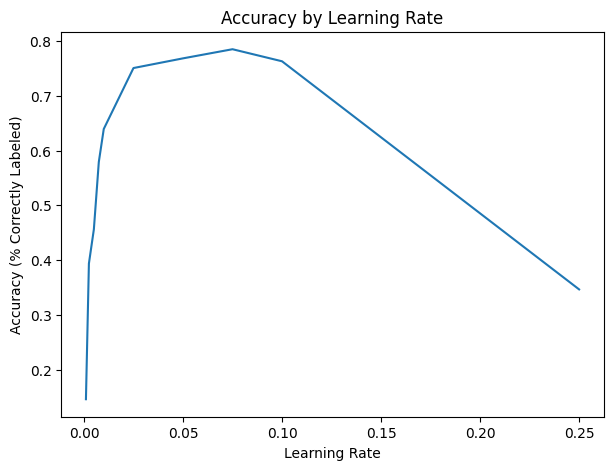

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.plot(lrs, accuracies)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (% Correctly Labeled)")
plt.title('Accuracy by Learning Rate')

In [ ]:
# Create different layer shapes to test
shapes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
accuracies = []
# Do a learning rate of .075 to maximize accuracy
alpha = .075
# Store accuracy for each layer shape
for node_num in shapes:
    N = Network((784, node_num, 10), alpha)
    # Train with the shape
    N.train(x_train, y_train)
    accuracies.append(N.test(x_test, y_test, x_test.shape[0]))

Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete


Text(0.5, 1.0, 'Accuracy by Hidden Layer Shape')

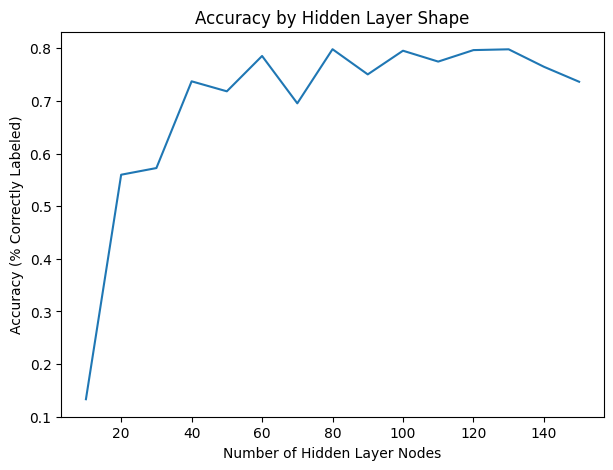

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.plot(shapes, accuracies)
plt.xlabel("Number of Hidden Layer Nodes")
plt.ylabel("Accuracy (% Correctly Labeled)")
plt.title('Accuracy by Hidden Layer Shape')